<a href="https://colab.research.google.com/github/kacper38/Euler/blob/master/functional_api_working_calfa_st.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np

import glob
import os 
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

# wyczyścić ładnie!


In [14]:
tf.__version__

'2.4.1'

In [15]:
def get_file(datapath, dataset_path=None):
    if dataset_path:
        return np.load(dataset_path + datapath, allow_pickle = True)
    else:
      return np.load(datapath, allow_pickle=True)

dataset_path = "/content/q3_pcacc_regular_ss.npy"
#data = get_file("/q3_pcacc_regular_ss.npy", dataset_path)
data = get_file(dataset_path)


print(data[0].shape)

(2978,)


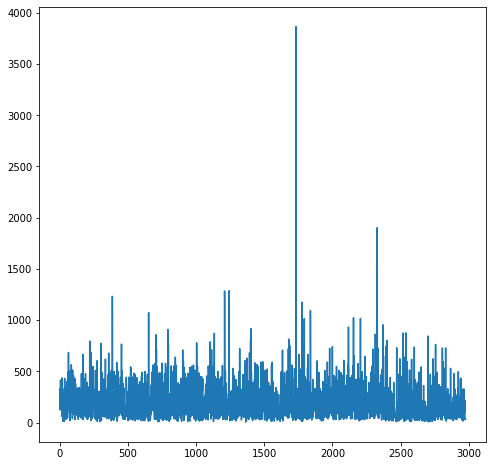

In [16]:
fig = plt.figure(figsize=(8,8))
ax2 = fig.add_subplot()
ax2.plot([len(x)/3 for x in data[0]])
plt.show()

# number is divided by 3, as every element in data[0] 
 
# is composed of [x1 y1 z1 x2 y2 z2 ... xN yN zN] components
 
# and each carbon has its own set of xyz, so there would be N/3 carbons in an element

In [17]:
def get_cutoff_info(cutoff):
    num_outliers = len([1 for x in data[0] if len(x)/3 >= cutoff])
    

    num_samples = len([1 for x in data[0] if len(x)/3 <= cutoff])
    print(f"\nnumber samples without outliers with cutoff={cutoff} is: {num_samples}")
    print(f"number of outliers with cutoff={cutoff} is: {num_outliers}")
    print(f"percent of data used without outliers: {round(num_samples/len(data[0]) * 100,3)}%")
    print("*"*56)

In [18]:
for cutoff in [400, 500, 550, 600, 650, 700, 800, 1000]:
    get_cutoff_info(cutoff)


number samples without outliers with cutoff=400 is: 2669
number of outliers with cutoff=400 is: 313
percent of data used without outliers: 89.624%
********************************************************

number samples without outliers with cutoff=500 is: 2827
number of outliers with cutoff=500 is: 154
percent of data used without outliers: 94.929%
********************************************************

number samples without outliers with cutoff=550 is: 2872
number of outliers with cutoff=550 is: 107
percent of data used without outliers: 96.441%
********************************************************

number samples without outliers with cutoff=600 is: 2904
number of outliers with cutoff=600 is: 74
percent of data used without outliers: 97.515%
********************************************************

number samples without outliers with cutoff=650 is: 2919
number of outliers with cutoff=650 is: 59
percent of data used without outliers: 98.019%
**********************************

# cutoff 600 seems reasonable, losing less than 2% of the data, while using 98.019%

# as it is computationally wise to get rid of outliers, especially such big ones. I will not use them here, for speed purposes


In [19]:
X = [x for x in data[0] if len(x)/3 <= 650]
Y = [y for y in data[1] if len(y) <= 650]
print(len(X))
print(len(Y))

2919
2919


In [24]:
X_pad = tf.keras.preprocessing.sequence.pad_sequences(X, padding = 'post', dtype='float32')
Y_pad = tf.keras.preprocessing.sequence.pad_sequences(Y, padding = 'post')
assert(X_pad.shape[0] == Y_pad.shape[0])
print(X_pad.shape)
print(Y_pad.shape)

(2919, 1941)
(2919, 647)


In [25]:
X_pad[0].shape

(1941,)

In [26]:
SAMPLE_LENGTH = X_pad.shape[1]
NUMBER_OF_LABELS = Y_pad.shape[1] # is basically sample length/3
NUMBER_OF_SAMPLES = X_pad.shape[0]
NUMBER_OF_FEATURES = 3

In [27]:
print(SAMPLE_LENGTH,  NUMBER_OF_LABELS, NUMBER_OF_SAMPLES, NUMBER_OF_FEATURES)
print(NUMBER_OF_FEATURES)

1941 647 2919 3
3


# for now let's rehape X, so each element in sample has 3 features, that is xyz coordinate

In [28]:
Y = Y_pad
X = np.reshape(X_pad, (NUMBER_OF_SAMPLES, NUMBER_OF_LABELS, NUMBER_OF_FEATURES))
print(X[1].shape)
print(X[1200].shape)
print(X[2544].shape)
X[100]

(647, 3)
(647, 3)
(647, 3)


array([[16.947, 35.566,  4.55 ],
       [18.83 , 37.58 ,  1.899],
       [17.908, 40.951,  3.422],
       ...,
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ]], dtype=float32)

In [67]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, Y, test_size=0.2, random_state=1)

#20 procent of data is left for trainingX
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2335, 647, 3)
(2335, 647)
(584, 647, 3)
(584, 647)


In [68]:
print("X train shape:",X_train.shape)
print("Y train shape:",y_train.shape)
print("X test shape:",X_test.shape)
print("Y test shape:",y_test.shape)

X train shape: (2335, 647, 3)
Y train shape: (2335, 647)
X test shape: (584, 647, 3)
Y test shape: (584, 647)


In [31]:
from tensorflow.keras.layers import Embedding,Masking, RNN, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Input, LocallyConnected2D
from tensorflow.keras.layers import Dropout, Flatten, Dense, Activation
from tensorflow.keras.models import Sequential

In [83]:
samples, timesteps, features = NUMBER_OF_SAMPLES, NUMBER_OF_LABELS, NUMBER_OF_FEATURES
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

inputs_ = tf.keras.Input(shape=( timesteps, features ), dtype='float32')

lambda1 = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,1))(inputs_)


mask1 = tf.keras.layers.Masking(mask_value= 0.,
                                 input_shape=(timesteps, features))(lambda1)
conv1 = tf.keras.layers.Conv2D(filters=16, kernel_size=2,
          padding='same', activation = tf.nn.relu)(mask1)


pad1 = tf.keras.layers.ZeroPadding2D(padding=(0,4))(conv1)
maskl1= Masking(mask_value= 0., input_shape=(timesteps, features))(pad1)

locally_connected1= LocallyConnected2D(filters=16, kernel_size=(1,9), padding='valid')(maskl1)



mask2 = tf.keras.layers.Masking(mask_value= 0.,
                                 input_shape=(timesteps, features))(locally_connected1)
conv2 = tf.keras.layers.Conv2D(filters=16, kernel_size=2,
          padding='same', activation = tf.nn.relu)(mask2)


mask3 = tf.keras.layers.Masking(mask_value= 0.,
                                 input_shape=(timesteps, features))(conv2)
conv3 = tf.keras.layers.Conv2D(filters=32, kernel_size=2,
          padding='same', activation = tf.nn.relu)(mask3)

pad2 = tf.keras.layers.ZeroPadding2D(padding=(0,2))(conv3)
maskl2= Masking(mask_value= 0., input_shape=(timesteps, features))(pad2)

locally_connected2= LocallyConnected2D(filters=32, kernel_size=(1,5), padding='valid')(maskl2)



dropout = tf.keras.layers.Dropout(0.2)(locally_connected2)
mask4 = tf.keras.layers.Masking(mask_value= 0.,
                                 input_shape=(timesteps, features))(dropout)
conv4 = tf.keras.layers.Conv2D(filters=64, kernel_size=2,
          padding='same', activation = tf.nn.relu)(mask4)


mask5 = tf.keras.layers.Masking(mask_value= 0.,
                                 input_shape=(timesteps, features))(conv4)
conv5 = tf.keras.layers.Conv2D(filters=64, kernel_size=2,
          padding='same', activation = tf.nn.relu)(mask5)

pad3 = tf.keras.layers.ZeroPadding2D(padding=(0,1))(conv5)
maskl3= Masking(mask_value= 0., input_shape=(timesteps, features))(pad3)

locally_connected3= LocallyConnected2D(filters=64, kernel_size=(1,3), padding='valid')(maskl3)


mask6 = tf.keras.layers.Masking(mask_value= 0.,
                                input_shape=(timesteps, features))(locally_connected3)
conv6 = tf.keras.layers.Conv2D(filters=64, kernel_size=2,
          padding='same', activation = tf.nn.relu)(mask6)


mask7 = tf.keras.layers.Masking(mask_value= 0.,
                                input_shape=(timesteps, features))(conv6)

out = LocallyConnected2D(4, 1 ,activation='softmax')(mask7)

model = tf.keras.Model(inputs_, out)

model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 647, 3)]          0         
_________________________________________________________________
lambda_25 (Lambda)           (None, 1, 647, 3)         0         
_________________________________________________________________
masking_150 (Masking)        (None, 1, 647, 3)         0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 1, 647, 16)        208       
_________________________________________________________________
zero_padding2d_12 (ZeroPaddi (None, 1, 655, 16)        0         
_________________________________________________________________
masking_151 (Masking)        (None, 1, 655, 16)        0         
_________________________________________________________________
locally_connected2d_54 (Loca (None, 1, 647, 16)        150

In [84]:
for i,l in enumerate(model.layers):
    print(f'layer {i}: {l}')
    print(f'has input mask: {l.input_mask}')
    print(f'has output mask: {l.output_mask}\n') 

layer 0: <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f34eed65cd0>
has input mask: None
has output mask: None

layer 1: <tensorflow.python.keras.layers.core.Lambda object at 0x7f345df0fc10>
has input mask: None
has output mask: None

layer 2: <tensorflow.python.keras.layers.core.Masking object at 0x7f34e5f74290>
has input mask: None
has output mask: KerasTensor(type_spec=TensorSpec(shape=(None, 1, 647), dtype=tf.bool, name=None), name='masking_150/Squeeze:0')

layer 3: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f34eed78c90>
has input mask: KerasTensor(type_spec=TensorSpec(shape=(None, 1, 647), dtype=tf.bool, name=None), name='masking_150/Squeeze:0')
has output mask: None

layer 4: <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f34eed61d90>
has input mask: None
has output mask: None

layer 5: <tensorflow.python.keras.layers.core.Masking object at 0x7f34eed86d50>
has input mask: None
has output mask: KerasTensor(type

In [69]:
y_train = tf.expand_dims(y_train,1)
y_test = tf.expand_dims(y_test, 1)

In [70]:
print(y_train.shape)
print(y_test.shape)

(2335, 1, 647)
(584, 1, 647)


In [71]:
depth = 4
y_train1 = tf.one_hot(y_train,depth)
y_test1 = tf.one_hot(y_test, depth)

print(y_train1.shape)
print(y_test1.shape)

(2335, 1, 647, 4)
(584, 1, 647, 4)


In [72]:
y_train1

<tf.Tensor: shape=(2335, 1, 647, 4), dtype=float32, numpy=
array([[[[0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         ...,
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.]]],


       [[[0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         ...,
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.]]],


       [[[0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         ...,
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.]]],


       ...,


       [[[0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         ...,
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.]]],


       [[[0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         ...,
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.]]],


       [[[0., 0., 0., 1.],


In [85]:
batch_size = 16
epochs= 15

model.compile(loss='categorical_crossentropy', optimizer='adam',
                 metrics =['accuracy', 'mae'])

history = model.fit(X_train, y_train1, batch_size=batch_size, epochs=epochs,
          validation_split=0.125, callbacks=callback)

Epoch 1/15
128/128 [==============================] - 89s 247ms/step - loss: 1.0050 - accuracy: 0.7534 - mae: 0.2767 - val_loss: 0.3847 - val_accuracy: 0.7908 - val_mae: 0.1076
Epoch 2/15
128/128 [==============================] - 15s 117ms/step - loss: 0.3752 - accuracy: 0.8035 - mae: 0.1050 - val_loss: 0.3751 - val_accuracy: 0.8143 - val_mae: 0.1058
Epoch 3/15
128/128 [==============================] - 16s 124ms/step - loss: 0.3668 - accuracy: 0.8213 - mae: 0.1038 - val_loss: 0.3677 - val_accuracy: 0.8230 - val_mae: 0.1047
Epoch 4/15
128/128 [==============================] - 16s 126ms/step - loss: 0.3573 - accuracy: 0.8289 - mae: 0.1021 - val_loss: 0.3615 - val_accuracy: 0.8266 - val_mae: 0.1035
Epoch 5/15
128/128 [==============================] - 15s 117ms/step - loss: 0.3454 - accuracy: 0.8338 - mae: 0.0995 - val_loss: 0.3554 - val_accuracy: 0.8286 - val_mae: 0.1028
Epoch 6/15
128/128 [==============================] - 15s 117ms/step - loss: 0.3426 - accuracy: 0.8344 - mae: 0.099

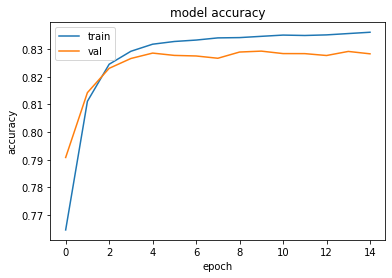

In [86]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

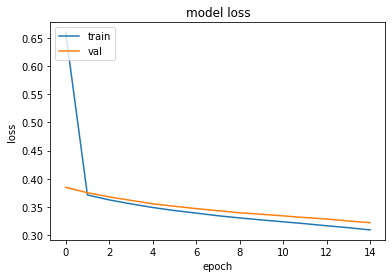

In [87]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [88]:
X_test.shape

(584, 647, 3)

In [41]:
X_test = tf.squeeze(X_test)
X_test.shape

TensorShape([584, 647, 3])

In [89]:
score = model.evaluate(X_test, y_test1, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

19/19 [==============================] - 1s 42ms/step - loss: 0.3060 - accuracy: 0.8398 - mae: 0.0900
Test loss: 0.3059849143028259
Test accuracy: 0.8397583365440369


In [43]:
X_test[86][602:604]

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[-16.184,  28.743,  51.675],
       [  0.   ,   0.   ,   0.   ]], dtype=float32)>

In [90]:
k = X_test[86]
k = np.expand_dims(k, 0)


ynew = model.predict(k)
wc = np.argmax(tf.squeeze(ynew), axis=-1)
print(wc.shape)

(647,)


In [91]:
yt = np.argmax(y_test1[86], axis=2)
print(yt.shape)
acc = 0
for i in range(len(yt[0])):
    if wc[i] == yt[0][i]:
        acc+=1
acc /= len(yt[0])

print(acc)

(1, 647)
0.4868624420401855


In [92]:
def appendSpherical_np(xyz):
    ptsnew = np.hstack((xyz, np.zeros(xyz.shape)))
    xy = xyz[:,0]**2 + xyz[:,1]**2
    ptsnew[:,3] = np.sqrt(xy + xyz[:,2]**2)
    ptsnew[:,4] = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down
    #ptsnew[:,4] = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    ptsnew[:,5] = np.arctan2(xyz[:,1], xyz[:,0])
    return ptsnew

In [96]:
print(appendSpherical_np(np.array([-1,-2,-3])))

IndexError: ignored

In [49]:
for x,y in zip(yt[0],wc):
  print(f"{x} -> {y}")

3 -> 3
3 -> 3
3 -> 3
1 -> 3
1 -> 3
1 -> 2
3 -> 3
3 -> 3
3 -> 3
3 -> 1
3 -> 3
1 -> 3
1 -> 1
1 -> 1
1 -> 1
1 -> 1
1 -> 1
1 -> 1
1 -> 1
1 -> 1
3 -> 1
3 -> 3
3 -> 3
3 -> 3
1 -> 3
1 -> 3
1 -> 1
1 -> 1
1 -> 1
1 -> 3
1 -> 3
3 -> 2
2 -> 2
2 -> 2
2 -> 2
2 -> 2
1 -> 3
1 -> 3
1 -> 3
3 -> 1
3 -> 1
1 -> 3
1 -> 3
1 -> 1
1 -> 1
1 -> 1
1 -> 3
3 -> 3
3 -> 3
3 -> 3
3 -> 2
2 -> 2
2 -> 2
2 -> 2
2 -> 2
3 -> 3
3 -> 3
3 -> 1
3 -> 1
3 -> 3
3 -> 2
3 -> 3
3 -> 3
3 -> 3
3 -> 3
3 -> 3
1 -> 1
1 -> 1
1 -> 1
1 -> 1
1 -> 1
1 -> 1
1 -> 1
1 -> 1
1 -> 1
1 -> 1
1 -> 1
1 -> 1
1 -> 1
1 -> 1
1 -> 1
1 -> 1
3 -> 1
3 -> 3
3 -> 3
3 -> 3
3 -> 3
3 -> 2
3 -> 2
3 -> 2
2 -> 2
2 -> 2
2 -> 2
2 -> 2
3 -> 3
3 -> 3
3 -> 3
3 -> 3
3 -> 1
3 -> 1
3 -> 3
3 -> 3
3 -> 3
3 -> 3
3 -> 3
3 -> 3
3 -> 3
3 -> 3
3 -> 1
3 -> 1
3 -> 3
1 -> 3
1 -> 1
1 -> 1
1 -> 1
1 -> 1
1 -> 3
1 -> 3
3 -> 3
3 -> 1
1 -> 1
1 -> 1
1 -> 1
1 -> 1
1 -> 1
1 -> 1
1 -> 1
1 -> 1
1 -> 1
1 -> 1
1 -> 1
1 -> 1
1 -> 1
1 -> 1
1 -> 1
1 -> 1
3 -> 1
3 -> 3
3 -> 3
3 -> 3
3 -> 3
2 -> 3
2 -> 3